# Notebook Imports

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

%matplotlib inline

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

## Constants

In [3]:
FILE = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

# Step 1: Data Collection and Loading

* Large Movie Review Dataset [Link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

In [4]:
data = pd.read_csv(FILE)
df_full = pd.DataFrame(data)

df_full.drop([0], axis=0, inplace=True)
df_full.reset_index(drop=True, inplace=True)

df = df_full.sample(frac=0.3)
df.head()

,review,sentiment
42205,I have some of the older videos and dvds of Dr...,positive
24047,Thirst<br /><br />I found that this film was b...,positive
19732,Psychotic transsexual Bobbi murders the patien...,positive
22265,This movie is very disappointing for one who h...,negative
6578,"What a dreadful movie! For some reason, scient...",negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 42205 to 39748
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     15000 non-null  object
 1   sentiment  15000 non-null  object
dtypes: object(2)
memory usage: 351.6+ KB


In [6]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
review       0
sentiment    0
dtype: int64


In [7]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")


The shape of the data: (15000, 2)

The types of the data: 
review       object
sentiment    object
dtype: object



# Step 2: Data Preprocessing

* **Text Cleaning:** Remove any HTML tags, special characters, numbers, and other non-alphabetic characters.
* **Tokenization:** Split the reviews into individual words (tokens).
* **Stop Words Removal:** Remove common words that do not contribute to the sentiment, such as 'and', 'the', 'is', etc.
* **Lemmatization:** Reduce words to their base or root form.

### Text Cleaning

In [8]:
df.nunique()

review       14957
sentiment        2
dtype: int64

In [9]:
df = df.drop_duplicates()
print(df.shape)
df.head()

(14957, 2)


,review,sentiment
42205,I have some of the older videos and dvds of Dr...,positive
24047,Thirst<br /><br />I found that this film was b...,positive
19732,Psychotic transsexual Bobbi murders the patien...,positive
22265,This movie is very disappointing for one who h...,negative
6578,"What a dreadful movie! For some reason, scient...",negative


In [10]:
# remove html tags from text
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

### Tokenization, Stop Words Removal, Lemmatization

In [11]:
def clean_review(text, wl=WordNetLemmatizer(), 
               stop_words=set(stopwords.words('english'))):
    # Remove HTML tags
    cleaned_text = remove_html_tags(text)
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(wl.lemmatize(word))
    
    filtered_words = ' '.join(filtered_words)    
     
    return filtered_words

In [12]:
%%time
nested_list = df.review.apply(clean_review)
df['review'] = nested_list

CPU times: user 38.4 s, sys: 117 ms, total: 38.6 s
Wall time: 38.6 s


In [13]:
df.head()

,review,sentiment
42205,older video dvd played adore doctor different ...,positive
24047,thirsti found film beautifully crafted cinemat...,positive
19732,psychotic transsexual bobbi murder patient ang...,positive
22265,movie disappointing one read book written rafa...,negative
6578,dreadful movie reason scientific laboratory ou...,negative


In [14]:
nested_list.head()

42205    older video dvd played adore doctor different ...
24047    thirsti found film beautifully crafted cinemat...
19732    psychotic transsexual bobbi murder patient ang...
22265    movie disappointing one read book written rafa...
6578     dreadful movie reason scientific laboratory ou...
Name: review, dtype: object

In [15]:
label_encoder = LabelEncoder() 
df['category']= label_encoder.fit_transform(df['sentiment']) 

df.head()

,review,sentiment,category
42205,older video dvd played adore doctor different ...,positive,1
24047,thirsti found film beautifully crafted cinemat...,positive,1
19732,psychotic transsexual bobbi murder patient ang...,positive,1
22265,movie disappointing one read book written rafa...,negative,0
6578,dreadful movie reason scientific laboratory ou...,negative,0


### Positive and Negative Words

In [16]:
# Identify the index of positive review
ids_positive = df[df.category == 1].index
ids_positive

Index([42205, 24047, 19732,  5822, 28291, 42969, 25332,  9692, 47815, 27602,
       ...
       45092, 25149, 34067,  2420, 25817, 21758, 12457, 38773, 22226, 39748],
      dtype='int64', length=7437)

In [17]:
# Identify the index of negative review
ids_negative = df[df.category == 0].index
ids_negative

Index([22265,  6578, 12421, 38283, 23448,  8103, 29046, 29208, 42825, 43910,
       ...
        5184,  4827, 22030, 43494,  3504, 35789, 16118, 15415, 19655,  7721],
      dtype='int64', length=7520)

In [18]:
nested_list_positive = nested_list.loc[ids_positive]
nested_list_negative = nested_list.loc[ids_negative]

nested_list_positive.shape, nested_list_negative.shape

((7437,), (7520,))

In [19]:
list_positive = [item for sublist in nested_list_positive for item in sublist.split(" ")]
positive_words = pd.Series(list_positive).value_counts()

list_negative = [item for sublist in nested_list_negative for item in sublist.split(" ")]
negative_words = pd.Series(list_negative).value_counts()

positive_words.shape[0], negative_words.shape[0]

(39536, 38308)

In [20]:
positive_words[:10]

film         14307
movie        12720
one           8020
like          5306
time          4511
good          4418
story         4099
character     3985
great         3843
see           3658
Name: count, dtype: int64

In [21]:
negative_words[:10]

movie        17026
film         12954
one           7916
like          6792
would         4657
even          4612
time          4414
bad           4303
good          4284
character     4211
Name: count, dtype: int64

# Step 3: Exploratory Data Analysis (EDA)

* Visualize the distribution of reviews by sentiment (positive vs. negative)
* Analyze the most common words in positive and negative reviews

In [22]:
amount_of_positive_review = df.category.value_counts()[1]
amount_of_negative_review = df.category.value_counts()[0]

amount_of_positive_review, amount_of_negative_review

(7437, 7520)

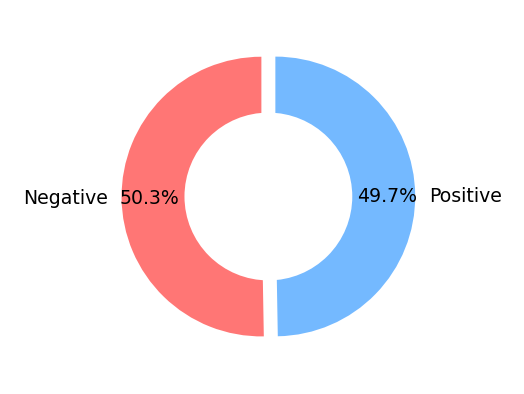

In [23]:
categoty_names = ['Negative', 'Positive']
sizes = [amount_of_negative_review, amount_of_positive_review]
custom_colours = ['#ff7675', '#74b9ff']
offset = [0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

#draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

### Word Cloud of Positive and Negative Reviews

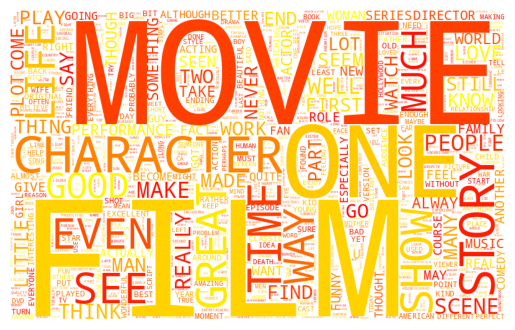

In [24]:
# Generate the text as a string for the Word Cloud
positive_str = ' '.join(list_positive)

wc = WordCloud(background_color='white', max_words=1000, colormap='autumn', width=800, height=500)
wc.generate(positive_str.upper())
plt.axis("off")
plt.imshow(wc)

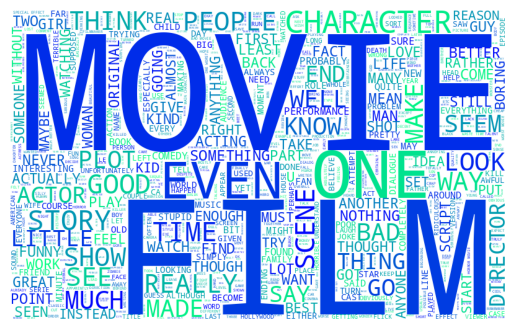

In [25]:
# Generate the text as a string for the Word Cloud
negative_str = ' '.join(list_negative)

wc = WordCloud(background_color='white', max_words=1000, colormap='winter', width=800, height=500)
wc.generate(negative_str.upper())
plt.axis("off")
plt.imshow(wc)

# Step 4: Model Preparation

In [26]:
max_length = max(len(sublist) for sublist in nested_list)
print(max_length)

5017


In [27]:
df.reset_index()
df.head()

,review,sentiment,category
42205,older video dvd played adore doctor different ...,positive,1
24047,thirsti found film beautifully crafted cinemat...,positive,1
19732,psychotic transsexual bobbi murder patient ang...,positive,1
22265,movie disappointing one read book written rafa...,negative,0
6578,dreadful movie reason scientific laboratory ou...,negative,0


In [28]:
data_dict = {
    "Preprocessed Review": df['review'],
    "Target": df['category']
}

df_prep = pd.DataFrame(data_dict)
df_prep.head()

,Preprocessed Review,Target
42205,older video dvd played adore doctor different ...,1
24047,thirsti found film beautifully crafted cinemat...,1
19732,psychotic transsexual bobbi murder patient ang...,1
22265,movie disappointing one read book written rafa...,0
6578,dreadful movie reason scientific laboratory ou...,0


In [29]:
count_vect = CountVectorizer(ngram_range=(1, 2))        
transformer = TfidfTransformer(norm='l2', sublinear_tf=True)
counts = count_vect.fit_transform(df_prep['Preprocessed Review'])

X = transformer.fit_transform(counts)
y = np.array(df_prep['Target'].values, dtype='float64')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11965, 1102714), (2992, 1102714), (11965,), (2992,))

In [31]:
LABELS = ['Negative', 'Positive']

In [32]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a confusion matrix using the true and predicted labels.

    Args:
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.
        labels (array-like): The list of labels to index the matrix.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Step 5: Model Training & Evaluation

## Logistic Regression

In [33]:
logreg = LogisticRegression(random_state=42, solver="saga")

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

accuracy_score(y_test, y_pred_lr)

0.8619652406417112

In [34]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      1504
         1.0       0.85      0.88      0.86      1488

    accuracy                           0.86      2992
   macro avg       0.86      0.86      0.86      2992
weighted avg       0.86      0.86      0.86      2992



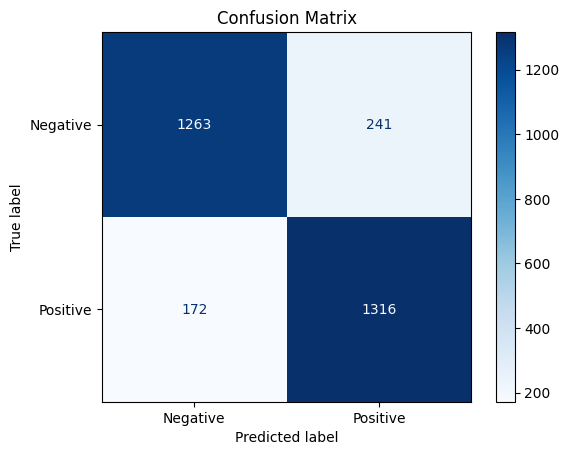

In [35]:
plot_confusion_matrix(y_test, y_pred_lr, LABELS)

## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)

accuracy_score(y_test, y_pred_rf)

0.8288770053475936

In [37]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83      1504
         1.0       0.82      0.83      0.83      1488

    accuracy                           0.83      2992
   macro avg       0.83      0.83      0.83      2992
weighted avg       0.83      0.83      0.83      2992



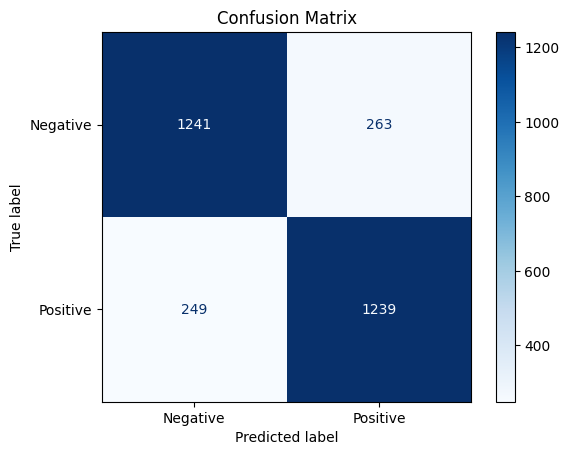

In [38]:
plot_confusion_matrix(y_test, y_pred_rf, LABELS)